In [4]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
from keras.preprocessing.image import load_img
from keras.preprocessing.image import save_img
from keras.preprocessing.image import img_to_array
from PIL import Image
import keras
from tensorflow.keras import datasets, layers, models


# **Data loading & preprocessing**

---


In [5]:
#load the labels in array

#your path
path_train = '.../counting/train/images/'
path_test = '.../counting/val/images/'

labels_train = pd.read_csv('.../counting/train/train_ground_truth.txt')
labels_train = labels_train['count']

labels_val = pd.read_csv('.../counting/val/val_ground_truth.txt')
labels_val = labels_val['count']


# convert this 1D array to 2D array
train_labels = np.expand_dims(labels_train, axis=1)
val_labels = np.expand_dims(labels_val, axis=1)

In [6]:
#select only the label apple or not apple
train_labels = train_labels[0:18449]
val_labels = val_labels[0:969]

print(train_labels.size)
print(val_labels.size)

18449
969


In [7]:
#create the array for the training and val images
train_images = np.empty([18449, 32, 32, 3], dtype=np.uint8)
val_images = np.empty([969, 32, 32, 3], dtype=np.uint8)


In [8]:
#load the image in the main array and resize them

for i in range (0,18448):

    image_name = path_train + 'images_' + "%05d" % i + '.png'
  
    image_i = Image.open(image_name)

    #resize image
    new_image = image_i.resize((32, 32))

    #conv array
    array_image = img_to_array(new_image)

    train_images[i, :, :, :] = array_image
    

    

In [9]:
#same for val images

for i in range (0,968):

  image_name = path_test + 'images_' + "%05d" % i + '.png'
  
  image_i = Image.open(image_name)

  #resize image
  new_image = image_i.resize((32, 32))

  #conv array
  array_image = img_to_array(new_image)

  val_images[i, :, :, :] = array_image

In [10]:
#normalize array, make values between 0 and 1
train_images, val_images = train_images / 255.0, val_images / 255.0

class_names = ['0', '1']

# **CNN training**

---


In [11]:
opt = keras.optimizers.Adam(learning_rate=0.0001) # choose an optimizer - no need to understand

# load VGG16 pre-trained weights to start our CNN, without dense layer 
base_model = keras.applications.VGG16(weights="imagenet", include_top=False)

# add a global average pooling layer to the convolutional based
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)

# add 1 neuron for the class label to the output layer.
# use sigmoid activation function to make this output a float value between 0 and 1
class_output = keras.layers.Dense(1, activation="sigmoid")(avg)

# create output layer
model = keras.Model(inputs=base_model.input, outputs=[class_output])

# use binary cross entropy loss for class prediction and mse loss for bounding box
# regression
model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[0.8, 0.2], optimizer=opt, metrics=["accuracy"])

58892288/58889256 [==============================] - 21s 0us/step


In [12]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)  

**Compile and train**

In [13]:
history = model.fit(train_images, train_labels, epochs=5, validation_data=(val_images, val_labels),shuffle=True)


Epoch 1/5
577/577 [==============================] - 708s 1s/step - loss: 0.0973 - accuracy: 0.9536 - val_loss: 0.0823 - val_accuracy: 0.9608
Epoch 2/5
577/577 [==============================] - 703s 1s/step - loss: 0.0642 - accuracy: 0.9717 - val_loss: 0.0635 - val_accuracy: 0.9732
Epoch 3/5
577/577 [==============================] - 707s 1s/step - loss: 0.0499 - accuracy: 0.9767 - val_loss: 0.0652 - val_accuracy: 0.9721
Epoch 4/5
577/577 [==============================] - 701s 1s/step - loss: 0.0432 - accuracy: 0.9809 - val_loss: 0.0608 - val_accuracy: 0.9752
Epoch 5/5
577/577 [==============================] - 691s 1s/step - loss: 0.0337 - accuracy: 0.9854 - val_loss: 0.0591 - val_accuracy: 0.9804


**Evaluate the model**

31/31 - 4s - loss: 0.0591 - accuracy: 0.9804


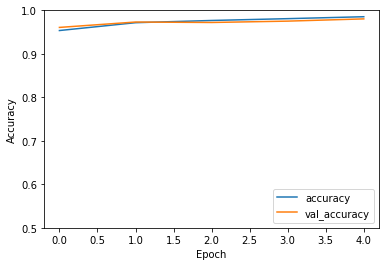

In [14]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(val_images,  val_labels, verbose=2)

In [15]:
print(test_acc)

0.9803921580314636


**Saving the CNN**

---

In [17]:
model.save('Binary_sig_R1_v4.h5')